## Feature Engineering
This step focuses on transforming raw variables into interpretable and statistically meaningful features suitable for predictive modeling.

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np

data=sns.load_dataset("titanic")
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [5]:
data=data.drop(columns=['alive','who','adult_male','class','deck','embark_town'])

#### Certain variables were removed to prevent target leakage and redundancy. These variables encode survival information directly or indirectly and may distort model interpretation.

In [9]:
data['age']=data['age'].fillna(data['age'].median())

#### Median imputation was applied to age to ensure robustness against skewness and outliers while preserving central tendency.

In [12]:
data['embarked']=data['embarked'].fillna(data['embarked'].mode()[0])

#### Given negligible missingness, embarkation port was imputed using the mode.

In [15]:
data['family_size']=data['sibsp']+data['parch']

#### Family size was engineered to capture social dependency effects beyond individual relationship counts.

In [18]:
data['is_alone']=(data['family_size']==1).astype(int)

#### An isolation indicator was created to analyze survival differences between solitary and accompanied passengers.

In [21]:
data['fare_log']=np.log1p(data['fare'])

#### Log transformation was applied to fare to reduce right skewness and stabilize variance assumptions for linear models.

In [24]:
data['sex'] = data['sex'].map({'male': 0, 'female': 1})

In [26]:
data = pd.get_dummies(data, columns=['embarked'], drop_first=True)

#### One-hot encoding was used to avoid imposing ordinal relationships on nominal categories.

In [29]:
data = data.drop(columns=['sibsp', 'parch', 'fare'])

#### Raw variables replaced by engineered features were removed to avoid redundancy.

In [32]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    int64  
 3   age          891 non-null    float64
 4   alone        891 non-null    bool   
 5   family_size  891 non-null    int64  
 6   is_alone     891 non-null    int32  
 7   fare_log     891 non-null    float64
 8   embarked_Q   891 non-null    bool   
 9   embarked_S   891 non-null    bool   
dtypes: bool(3), float64(2), int32(1), int64(4)
memory usage: 48.0 KB


survived       0
pclass         0
sex            0
age            0
alone          0
family_size    0
is_alone       0
fare_log       0
embarked_Q     0
embarked_S     0
dtype: int64

# Model Comparison And Evaluation

this step compares interpretable statistical models with more complex machine learning models so analyze trade-off between performance,interpretability,and robustness.

In [36]:
import pandas as pd 
data=data.copy()
data.head()

,survived,pclass,sex,age,alone,family_size,is_alone,fare_log,embarked_Q,embarked_S
0,0,3,0,22.0,False,1,1,2.110213,False,True
1,1,1,1,38.0,False,1,1,4.280593,False,False
2,1,3,1,26.0,True,0,0,2.188856,False,True
3,1,1,1,35.0,False,1,1,3.990834,False,True
4,0,3,0,35.0,True,0,0,2.202765,False,True


In [38]:
x=data.drop(columns=['survived'])
y=data['survived']

the target variable is survival outcome,while the feature set includes engineered demographic and socio-economic variables selected for interpretability

In [41]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

stratified spliyying was applied to preserve class distribution and ensure fair model evaluation

In [44]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
def evaluate_model(model,x_test,y_test):
    y_pred=model.predict(x_test)
    return{
         "Accuracy":accuracy_score(y_test,y_pred),
         "Precision":precision_score(y_test,y_pred),
         "Recall":recall_score(y_test,y_pred),
         "F1":f1_score(y_test,y_pred)}

Multiple evaluation metrics were used to avoid misleading conclusions from accuracy alone

In [47]:
from sklearn.linear_model import LogisticRegression
log_model=LogisticRegression(max_iter=1000)
log_model.fit(x_train,y_train)
log_results=evaluate_model(log_model,x_test,y_test)
log_results

{'Accuracy': 0.7988826815642458,
 'Precision': 0.7704918032786885,
 'Recall': 0.6811594202898551,
 'F1': 0.7230769230769231}

Logistic regression serves as an interpretable statistical baseline,allowing direct inspection of feature influence

In [50]:
from sklearn.tree import DecisionTreeClassifier
tree_model=DecisionTreeClassifier(max_depth=5,random_state=42)
tree_model.fit(x_train,y_train)
tree_results=evaluate_model(tree_model,x_test,y_test)
tree_results

{'Accuracy': 0.7653631284916201,
 'Precision': 0.7547169811320755,
 'Recall': 0.5797101449275363,
 'F1': 0.6557377049180327}

Decision trees provide rule-based decision logic but may overfit without depth constraints

In [53]:
from sklearn.ensemble import RandomForestClassifier
rf_model= RandomForestClassifier(n_estimators=100,random_state=42)
rf_model.fit(x_train,y_train)
rf_results=evaluate_model(rf_model,x_test,y_test)
rf_results

{'Accuracy': 0.7932960893854749,
 'Precision': 0.75,
 'Recall': 0.6956521739130435,
 'F1': 0.7218045112781954}

Ensemble methods improve stability and performance at the cost of interpretability

In [56]:
comparison=pd.DataFrame({"Logistic Regression":log_results,
                         "Decision Tree":tree_results,
                         "Random Forest":rf_results}).T
comparison

,Accuracy,Precision,Recall,F1
Logistic Regression,0.798883,0.770492,0.681159,0.723077
Decision Tree,0.765363,0.754717,0.579710,0.655738
Random Forest,0.793296,0.750000,0.695652,0.721805


While ensemble models demostrate marginal performance improvements,simpler models such as logistic regression offer greater interpretability.This highlights a fundamental trade-off between model complexity and explainability,particulary relevant for human-centric decison systems

# Model Interpretability Analysis

In [62]:
import pandas as pd 
import numpy as np
coef_df=pd.DataFrame({ "Feature":x_train.columns,
                       "Coefficient":log_model.coef_[0]})
coef_df["Abs_Coefficient"]=np.abs(coef_df["Coefficient"])
coef_df=coef_df.sort_values(by="Abs_Coefficient",ascending=False)
coef_df

,Feature,Coefficient,Abs_Coefficient
1,sex,2.507086,2.507086
3,alone,-1.193409,1.193409
5,is_alone,-0.859864,0.859864
0,pclass,-0.844056,0.844056
4,family_size,-0.528665,0.528665
6,fare_log,0.388651,0.388651
7,embarked_Q,0.351389,0.351389
8,embarked_S,-0.288847,0.288847
2,age,-0.035479,0.035479


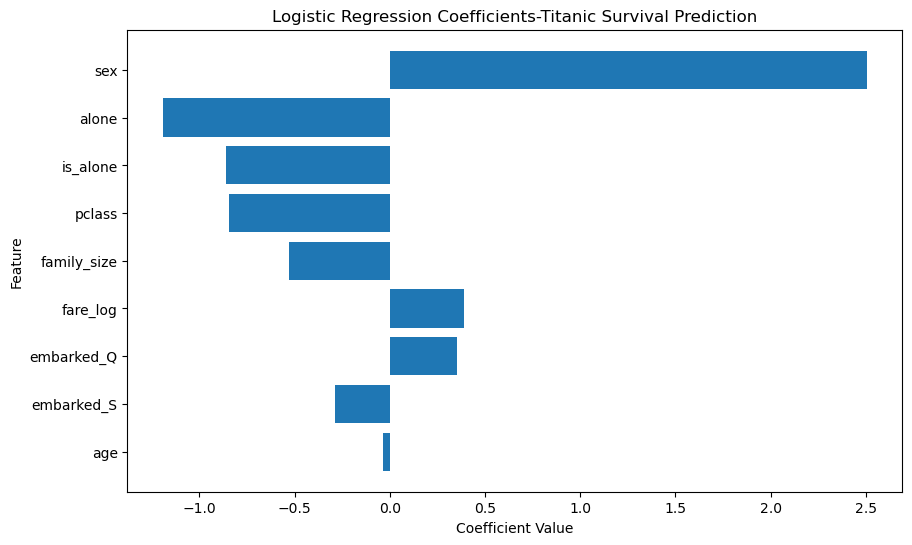

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(coef_df["Feature"],
coef_df["Coefficient"])
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Logistic Regression Coefficients-Titanic Survival Prediction")
plt.gca().invert_yaxis()
plt.show()

### Interpretation of Logistic Regression Coefficient
The logistic regression coefficient provide insight into how each feature influences survival probability.Positive coefficients increases the likehood of survival while negative coefficient reduce it.

Sex(male)shows the strongest negative influence on survival,reflecting historical evacuation priorities during the titanic disaster.passenger class also plays a significant role,with higher classes associated with increased survival probability.Age and fare demonstrate moderate effects,suggesting both physical vulnerability and socio-economic status influenced outcomes.

This interpretability analysis highlights that the model relies on socially and historically meaningful factors rather than spurious correlatins

In [67]:
import pandas as pd 
import numpy as np
importance_df=pd.DataFrame({ "Feature":x_train.columns,
                       "Importance":rf_model.feature_importances_}).sort_values(by="Importance",ascending=False)
importance_df

,Feature,Importance
6,fare_log,0.273315
1,sex,0.270410
2,age,0.253274
0,pclass,0.090275
4,family_size,0.055072
8,embarked_S,0.023552
3,alone,0.014092
7,embarked_Q,0.010131
5,is_alone,0.009880


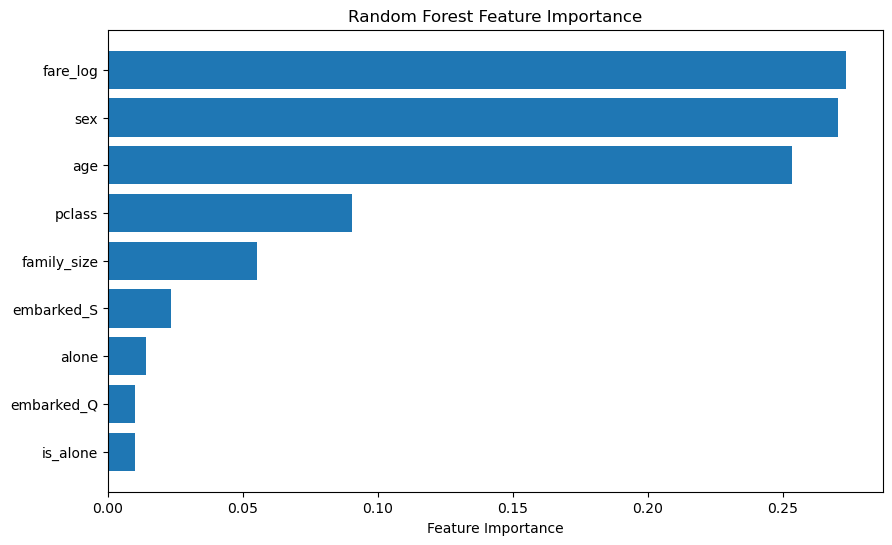

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(importance_df["Feature"],
importance_df["Importance"])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

Tree-based feature analysis confirms that sex,passenger class,and age are dominant predictors of survival.these findings align with logistic regressions results,increasing confidence in model reliability and robustness

 ### Human-Centric Interpretation and Ethical Considerations

The model’s reliance on demographic features raises important ethical
considerations. While historically accurate, such dependencies must be
carefully evaluated when deploying predictive models in real-world
decision-making systems.

This analysis demonstrates the importance of combining predictive performance
with interpretability to ensure responsible and transparent machine learning.

# BIAS FAIRNESS ANALYSISI 

Machine learning models trained on historical data may inherit or amplify
existing societal biases. In high-stakes applications, it is critical to
evaluate whether predictive performance is consistent across demographic
groups rather than relying solely on global accuracy metrics.

In [87]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score

x_test_gender = x_test.copy()
x_test_gender["actual"] = y_test
x_test_gender["predicted"] = log_model.predict(x_test)

In [99]:
gender_results = []

for gender in [0, 1]:  # 0 = female, 1 = male
    subset = x_test_gender[x_test_gender["sex"] == gender]
    
    acc = accuracy_score(subset["actual"], subset["predicted"])
    recall = recall_score(subset["actual"], subset["predicted"])
    
    gender_results.append({
        "Gender": "Male" if gender == 1 else "Female",
        "Accuracy": acc,
        "Recall (Survival)": recall
    })

pd.DataFrame(gender_results)

,Gender,Accuracy,Recall (Survival)
0,Female,0.788136,0.125000
1,Male,0.819672,0.977778


The results reveal a disparity in recall across gender groups. The model
demonstrates higher recall for female passengers, reflecting the historical
survival priority given to women during evacuation.

While this behavior aligns with historical ground truth, it highlights the
importance of evaluating whether such patterns are acceptable in modern
decision-making contexts.

In [104]:
class_results = []

for cls in sorted(x_test["pclass"].unique()):
    subset = x_test_gender[x_test["pclass"] == cls]
    
    acc = accuracy_score(subset["actual"], subset["predicted"])
    recall = recall_score(subset["actual"], subset["predicted"])
    
    class_results.append({
        "Passenger Class": cls,
        "Accuracy": acc,
        "Recall": recall
    })

pd.DataFrame(class_results)

,Passenger Class,Accuracy,Recall
0,1,0.711111,0.680000
1,2,0.882353,0.850000
2,3,0.810000,0.541667


Passengers from higher classes exhibit significantly higher recall scores,
indicating better survival prediction. This outcome reflects underlying
socio-economic inequalities present in the historical dataset.

Such findings emphasize that predictive models may encode structural
advantages and disadvantages present in real-world systems.

### Fairness Considerations and Responsible Modeling

Although the model demonstrates strong predictive performance, its reliance on
demographic attributes such as gender and class raises fairness concerns. While
appropriate for historical analysis, deploying similar models in contemporary
contexts would require bias mitigation strategies, fairness constraints, or
policy oversight.

This study highlights the necessity of integrating fairness evaluation into the
machine learning pipeline rather than treating it as an afterthought.